In [103]:
r.data = r.data.sort_values(by=['distance','traveltime'])

In [75]:
r.data['traveltime'].describe()

count    1.192090e+06
mean     2.377331e+03
std      1.588291e+03
min     -2.159000e+03
25%      9.500000e+02
50%      2.302000e+03
75%      3.720000e+03
max      8.916000e+03
Name: traveltime, dtype: float64

In [135]:
len(r.data)

1192090

In [137]:
len(r.data[r.data['traveltime']>=0])

1192069

# 20,000 rows with negative travel time. Is this a data leak
# or is it rows where

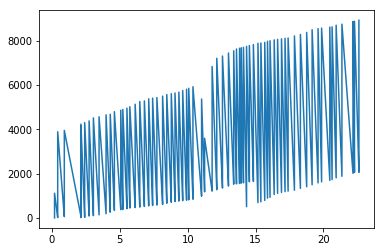

In [104]:
from matplotlib import pyplot as plt
plt.plot(r.data['distance'],r.data['traveltime'])
plt.show()

In [150]:
distances = r.data['distance'].unique()
ds = []
lower=[]
upper = []
means = []
lower2=[]
upper2=[]
lower3=[]
upper3=[]
for i in range(0,len(distances)-1):
    ds.append(distances[i])
    data = r.data[(r.data['distance']>=distances[i]) & (r.data['distance']<distances[i+1])]
    means.append(data['traveltime'].mean())
    upper2.append(data['traveltime'].quantile(0.25))
    upper3.append(data['traveltime'].quantile(0.05))
    upper.append(data['traveltime'].quantile(0.90))
    lower.append(data['traveltime'].quantile(0.75))
    lower2.append(data['traveltime'].quantile(0.10))
    lower3.append(data['traveltime'].quantile(0.05))
    
    

## Travel time as a function of distance.

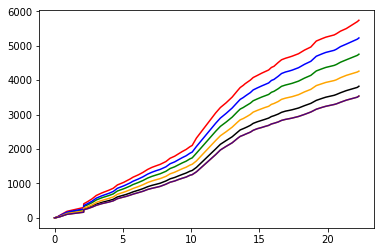

In [151]:
plt.plot(ds,means,color='green',label='mean')
plt.plot(ds,upper,color='red',label='lower')
plt.plot(ds,lower,color='blue',label='upper')
plt.plot(ds,lower2,color='black',label='upper')
plt.plot(ds,upper2,color='orange',label='upper')
plt.plot(ds,upper3,color='orange',label='pink')
plt.plot(ds,lower3,color='indigo',label='upper')

In [1]:
from dbanalysis import stop_tools
import pandas as pd
class BRModel():
    """
    Big route model class
    uses the distance of a stop from first stop on a route to compute predictions lalalala
    MAPE and r2 scores are not as good as they were in the notebook
    (we achieved 0.57 r2, and 7% MAPE on the time to complete the route)
    Should look into this.
    """
    def __init__ (self, route,variation,verbose=True,src='build',rgr='RandomForest',\
                mode='validate',features = ['base_time_dep','distance','weekend','rain','temp'],use_dummies=True):
        
        import json
        self.regr_type = rgr
        self.verbose = verbose
        self.route = route
        self.use_dummies = use_dummies
        self.variation = variation
        self.routes = json.loads(open('/home/student/dbanalysis/dbanalysis/resources/trimmed_routes.json').read())
        self.features = features
        self.route_array = self.routes[route][variation][1:]
        del(self.routes)
        if src == 'build':
            if not self.can_be_modelled():
                print('fuck')
                raise ValueError ('Missing data for modelling this route')

            self.gather_data()
            self.preprocess()
            if rgr == 'RandomForest':
                from sklearn.ensemble import RandomForestRegressor as rf
                self.rgr = rf()
            elif rgr == 'Linear':
                from sklearn.linear_model import LinearRegression as lr
                self.rgr = lr(fit_intercept=True)
            elif rgr == 'Neural':
                from sklearn.neural_network import MLPRegressor as mlpr
                self.rgr = mlpr(hidden_layer_sizes=(80,80,80,80))
                from sklearn.preprocessing import normalize
                
 
            #if mode == 'validate':
            #   if self.regr_type == 'Neural':
                    #self.validate_neural()
            #   else:
                    #self.validate_model()
            #lif mode == 'production':
                #self.build_full_model()
                #self.dump_model()
    def validate_neural(self):
        print('training regressor')
        self.model = self.rgr.fit(self.train_X,self.train_Y)
        preds = self.model.predict(self.test_1_X)
        from sklearn import metrics
        print('Validating...')
        print(metrics.r2_score(self.test_1_Y,preds))
        preds = self.model.predict(self.test_2_X)
        print(metrics.r2_score(self.test_2_Y,preds))
        print('calculated from norms-->')
        preds = preds * self.test_2_norm
        print(metrics.r2_score(self.test_2_real,preds))
        preds = self.model.predict(self.test_3_X)
        print(metrics.r2_score(self.test_3_Y,preds))
    def validate_model(self):
        self.data = self.data[self.data['traveltime']>0] 
        if self.verbose:
            print('Validating model on all trips...\n\n')
        
        self.train = self.data[self.data['year']==2016]
        self.test = self.data[self.data['year']==2017]
        self.model = self.rgr.fit(self.train_X,self.train_Y)
        preds = self.model.predict(self.test_1_X)
        from sklearn import metrics
        print('-----> Tested on all distances')
        print('R2:', metrics.r2_score(self.test_1_Y,preds))
        print('MAE:', metrics.mean_absolute_error(self.test_1_Y,preds)*self.norm[-1])
        print('MAPE:', ((abs(self.test_1_Y-preds)/self.test_1_Y)*100).mean())
        #add more options for testing eventually
        print('Validating model on longest trip')
        test2= self.test[self.test['distance']==self.test['distance'].max()]
        if self.regr_type == 'Neural':
            test2 = self.test[self.test['distance2']==self.test['distance2'].max()]
        preds = self.model.predict(test2[self.features])
        print('-----> ')
        print('R2:', metrics.r2_score(test2['traveltime'],preds))
        print('MAE:', metrics.mean_absolute_error(test2['traveltime'],preds)*self.norm[-1])
        print('MAPE:', ((abs(test2['traveltime']-preds)/test2['traveltime'])*100).mean())
        print('\n\n Validated on median trip -->')
        test2= self.test[self.test['distance']==self.test['distance'].median()]
        if self.regr_type == 'Neural':
            test2 = self.test[self.test['distance2']==self.test['distance2'].median()]
        
        preds = self.model.predict(test2[self.features])
        print('-----> ')
        print('R2:', metrics.r2_score(test2['traveltime'],preds))
        print('MAE:', metrics.mean_absolute_error(test2['traveltime'],preds)*self.norm[-1])
        print('MAPE:', ((abs(test2['traveltime']-preds)/test2['traveltime'])*100).mean())
        del(self.train)
        del(self.test)
        del(self.data)
        del(test2)


    def gather_data(self):
        if self.verbose:
            print('gathering data...')
        from dbanalysis import stop_tools
        arr = self.route_array
        import os
        to_concat = []
        for i in range(len(arr)-1):
            
            data = stop_tools.get_stop_link(arr[i],arr[i+1])
            to_concat.append(data)
            del(data)
        self.data = pd.concat(to_concat,axis=0)
        del to_concat
        

    def preprocess(self):
        if self.verbose:
            print('Preprocessing data')
        self.select_routes()
        self.clean_1()
        self.add_distances()
        self.add_base_departure_time()
        self.add_time_info()
        
        self.merge_weather()
        if self.use_dummies:
            self.add_dummies()
            self.features += self.dummy_features
    def select_routes(self):
        if self.verbose:
            print('parsing routeids')
        routeids = self.data['routeid'].unique()
        valid_routeids = [r for r in routeids if r.split('_')[0] == self.route]
        self.data = self.data[self.data['routeid'].isin(valid_routeids)]
    def clean_1(self):
        if self.verbose:
            print('dropping null values')
        self.data = self.data.dropna()
        
    def add_distances(self):
        if self.verbose:
            print('adding distances')
        s_getter =stop_tools.stop_getter()
        total_distance = 0
        r = self.route_array
        route_distances = {r[0]:0}
        
        for i in range(0, len(r)-1):
            distance = s_getter.get_stop_distance(str(r[i]),str(r[i+1]))
                
            total_distance += distance
            route_distances[r[i+1]]=total_distance
        self.data['distance']=self.data['stopA'].apply(lambda x: route_distances[x])
        del(s_getter)
    def add_base_departure_time(self):
        if self.verbose:
            print('adding base departure times')
       
        keys= self.data[self.data['stopA']==self.route_array[0]]
        keys['base_time_dep']=keys['actualtime_arr_from']
        keys2=keys[['tripid','dayofservice','routeid','base_time_dep']]
        self.data = pd.merge(self.data,keys2,on=['dayofservice','tripid','routeid'])
        
        self.data['traveltime']=self.data['actualtime_arr_from']-self.data['base_time_dep'] 
        #A number of rows have negative travel time. But its a really small number, so I guess they 
        #can go in the bin.
        self.data = self.data[self.data['traveltime']>0]
        del(keys)
        del(keys2)
    
    def add_time_info(self):
        if self.verbose:
            print('adding time information')
        time_format = "%d-%b-%y %H:%M:%S"
        self.data['dt']=pd.to_datetime(self.data['dayofservice'],format=time_format)
        self.data['day']=self.data['dt'].dt.dayofweek
        self.data['month']=self.data['dt'].dt.month
        self.data['hour'] = self.data['dt'].dt.hour
        self.data['weekend']=self.data['day']>4
        self.data['year']=self.data['dt'].dt.year
        self.data['date'] = self.data['dt'].dt.date
    def merge_weather(self,weather=None):
        if self.verbose:
            print('merging weather')
        if weather == None:
          
            weather = pd.read_csv('/home/student/dbanalysis/dbanalysis/resources/cleanweather.csv').dropna()
        weather['dt']=pd.to_datetime(weather['date'])
        weather['hour']=weather['dt'].dt.hour
        weather['date']=weather['dt'].dt.date
        
        self.data = pd.merge(self.data,weather,on=['date','hour'])
        del(weather)

    def add_dummies(self):
        if self.verbose:
            print('Making dummy features')
        self.data = pd.get_dummies(self.data,columns=['day','month','hour'])
        self.dummy_features = [col for col in self.data.columns\
                                if (col[0:3] == 'day' and col != 'dayofservice')\
                                or col[0:5] == 'month' or col[0:4] == 'hour']


    def can_be_modelled(self):
        if self.verbose:
            print('Checking for data files')
        import os
        base_dir = '/data/stops/'
        arr = self.route_array
        for i in range(len(arr)-1):
            
            if os.path.exists(base_dir+str(arr[i])+'/'+str(arr[i+1])+'.csv'):
                pass
            else:
                print('broken')
                input()
                return False
        return True


In [4]:
r=BRModel('15',1,rgr='Neural')

Checking for data files
gathering data...
Preprocessing data
parsing routeids
dropping null values
adding distances
adding base departure times


/home/student/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


adding time information
merging weather
Making dummy features


In [110]:
r.data[r.data['actualtime_arr_from'] > 86400]

,index,dayofservice,tripid,plannedtime_arr_from,plannedtime_dep_from,actualtime_arr_from,actualtime_dep_from,plannedtime_arr_to,actualtime_arr_to,routeid,...,day_4,day_5,day_6,month_1,month_2,month_3,month_4,month_5,month_6,hour_0
9505,46525,04-JAN-17 00:00:00,4094471,86481,86481,86420,86434,86543,86479,15_16,...,0,0,0,1,0,0,0,0,0,1
9506,46526,04-JAN-17 00:00:00,4094471,86543,86543,86479,86492,86638,86559,15_16,...,0,0,0,1,0,0,0,0,0,1
9507,46527,04-JAN-17 00:00:00,4094471,86638,86638,86559,86559,86652,86571,15_16,...,0,0,0,1,0,0,0,0,0,1
9508,46528,04-JAN-17 00:00:00,4094471,86652,86652,86571,86588,86695,86624,15_16,...,0,0,0,1,0,0,0,0,0,1
9509,46529,04-JAN-17 00:00:00,4094471,86695,86695,86624,86624,86763,86637,15_16,...,0,0,0,1,0,0,0,0,0,1
20601,46656,06-JAN-17 00:00:00,4094471,86199,86199,86481,86499,86271,86549,15_16,...,1,0,0,1,0,0,0,0,0,1
20602,46657,06-JAN-17 00:00:00,4094471,86271,86271,86549,86563,86315,86596,15_16,...,1,0,0,1,0,0,0,0,0,1
20603,46658,06-JAN-17 00:00:00,4094471,86315,86315,86596,86611,86405,86662,15_16,...,1,0,0,1,0,0,0,0,0,1
20604,46659,06-JAN-17 00:00:00,4094471,86405,86405,86662,86678,86432,86699,15_16,...,1,0,0,1,0,0,0,0,0,1
20605,46660,06-JAN-17 00:00:00,4094471,86432,86432,86699,86713,86481,86749,15_16,...,1,0,0,1,0,0,0,0,0,1


In [117]:
r.data[(r.data['tripid']==4094471) & (r.data['dayofservice']=='04-JAN-17 00:00:00')]['stopA'].unique()

array([6318, 6319, 7246, 6320, 4594, 4595, 4596, 4563, 1218, 1270, 1272,
       1273, 1274, 1275, 1276, 1277, 1219, 1220, 1221,  664,  665,  666,
        667,  668,  614,  615,  616,  617,  618,  619,  675, 4415, 7581,
       1283, 7579, 1285, 1016, 1017, 1018, 1019, 1020, 1076, 1077, 1078,
       1079, 1080, 1081, 1082, 1083, 1085, 1121, 1122, 1123, 1124, 1125,
       1127, 1130, 1140, 1141, 1142, 1143, 1144, 1145, 4869, 4870, 3007,
       6283])

In [116]:
r.data[r.data['distance']==0]['stopA'].unique()

array([6318])

In [80]:
train = r.data[r.data['year']==2016]
test = r.data[r.data['year']==2017]
traveltimes = test['traveltime']

## Normalize data - this is where the potential catch is

In [152]:
from sklearn.preprocessing import normalize
train = normalize(train[r.features+['traveltime']])
import pandas as pd
train = pd.DataFrame(train,columns = r.features+['traveltime'])

In [153]:
model = r.rgr.fit(train[r.features],train['traveltime'])

In [154]:
f = r.features + ['traveltime']

In [155]:
test = r.data[r.data['year']==2017]

In [89]:
test = test[test['distance']==test['distance'].median()]
traveltimes = test['traveltime']

In [156]:
traveltimes = test['traveltime']

In [157]:
test,norm = normalize(test[f],return_norm = True)
test = pd.DataFrame(test,columns=f)
preds = model.predict(test[r.features])

MemoryError: 

In [ ]:
distances = sorted(preds_test['distance'].unique())
preds_test = test['distance']
preds_test['traveltime'] = preds*norm

ds = []
lower=[]
upper = []
means = []
lower2=[]
upper2=[]
lower3=[]
upper3=[]
for i in range(0,len(distances)-1):
    ds.append(distances[i])
    data = preds_test[(test['distance']>=distances[i]) & (r.data['distance']<distances[i+1])]
    means.append(data['traveltime'].mean())
    upper2.append(data['traveltime'].quantile(0.25))
    upper3.append(data['traveltime'].quantile(0.05))
    upper.append(data['traveltime'].quantile(0.90))
    lower.append(data['traveltime'].quantile(0.75))
    lower2.append(data['traveltime'].quantile(0.10))
    lower3.append(data['traveltime'].quantile(0.05))
    
    

In [ ]:
plt.plot(ds,means,color='green',label='mean')
plt.plot(ds,upper,color='red',label='lower')
plt.plot(ds,lower,color='blue',label='upper')
plt.plot(ds,lower2,color='black',label='upper')
plt.plot(ds,upper2,color='orange',label='upper')
plt.plot(ds,upper3,color='orange',label='pink')
plt.plot(ds,lower3,color='indigo',label='upper')

In [91]:
from sklearn import metrics
print(metrics.r2_score(test['traveltime'],preds))
((abs(test['traveltime']-preds)/test['traveltime'])*100).mean()

0.8982799334170845


14.733059668531538

In [92]:
print(metrics.r2_score(traveltimes,preds*norm))
((abs(traveltimes-preds*norm)/traveltimes)*100).mean()

-0.08580037884842251


14.733059668531538

In [22]:
test['norm']=norm

In [25]:
test2=test[test['distance']==test['distance'].median()]

In [26]:
len(test2)

0

### Interestingly, the r2 scores are not so good when we undo the normalization,
#### but the mape scores are the same
Maybe we should just use this model, as it trains quickly enough, and has no serious problems.

In [99]:
test = r.data[r.data['year']==2017]
test = test[test['distance']==test['distance'].max()]
traveltimes = test['traveltime']
test,norm = normalize(test[f],return_norm = True)
test = pd.DataFrame(test,columns=f)
preds = model.predict(test[r.features])

In [100]:
from sklearn import metrics
print(metrics.r2_score(test['traveltime'],preds))
((abs(test['traveltime']-preds)/test['traveltime'])*100).mean()

0.981523670341646


4.19619468824826

In [101]:
print(metrics.r2_score(traveltimes,preds*norm))
((abs(traveltimes-preds*norm)/traveltimes)*100).mean()

0.8669513192621335


4.19619468824826

# Test on every individual distance

In [102]:
test = r.data[r.data['year']==2017]
r2 = 0
err = 0
count=0
distances = [0]+test['distance'].unique() 
for i in range(1,len(distances)-2):
    count+=1
    test = r.data[r.data['year']==2017]
    m = distances[i]
    mx = distances[i+2]
    test = test[(test['distance']>m) & (test['distance'] < mx)]
    traveltimes = test['traveltime']
    test,norm = normalize(test[f],return_norm = True)
    test = pd.DataFrame(test,columns=f)
    preds = model.predict(test[r.features])
    from sklearn import metrics
    print(metrics.r2_score(test['traveltime'],preds))
    print(((abs(test['traveltime']-preds)/test['traveltime'])*100).mean())
    print(metrics.r2_score(traveltimes,preds*norm))
    print(((abs(traveltimes-preds*norm)/traveltimes)*100).mean())
    r2+=metrics.r2_score(traveltimes,preds*norm)
    err+=((abs(traveltimes-preds*norm)/traveltimes)*100).mean()
    print('\n\n')

-0.6360447019885351
49.99232756259459
-4.175290209882119
49.99232756259459



0.6080084316115424
16.884531520805663
-0.06025856762595039
16.884531520805663



0.2020286735222644
33.477062427979014
-2.009444025561272
33.47706242797902



0.2722330175180011
32.63411682400374
-1.8990671752948782
32.63411682400373



0.31384142770741785
32.64709452683972
-1.911321889382557
32.64709452683972



0.2850940087115956
34.10183206333287
-2.330312894518105
34.10183206333287



0.37779212422403363
31.725556920451595
-2.170464176096211
31.725556920451595



0.5182704993330631
27.72809559644042
-1.6562669513942674
27.72809559644042



0.5618296261372137
26.234331504097778
-1.5157237525806382
26.234331504097785



0.5409084765200782
27.401661917054664
-1.8710762104764322
27.401661917054664



0.6255563421640442
24.752383116662784
-1.4710250211511142
24.752383116662784



0.6488128041231751
24.08668305958453
-1.310023028508259
24.08668305958453



0.6790864222350826
23.100335989781435
-1.16706678459779

ValueError: Found array with 0 sample(s) (shape=(0, 20)) while a minimum of 1 is required by the normalize function.

In [64]:
print(err/count)
print(r2/count)

23.830497136394136
-2.6978906553898123


### So it can be seen. Model sucks at predicting the short distances at the start of the route,

But is pretty good at getting the long distances. Over the median and its golden, under that and this model is genuinely awful and has no predictive power whatsoever

In [122]:
from dbanalysis import stop_tools
df=stop_tools.random_stop_data()

In [124]:
df['actualtime_arr_from'].min()

22745

In [134]:
r.data[r.data['traveltime']<0]['dayofservice'].unique()

array(['13-APR-16 00:00:00'], dtype=object)

In [128]:
len(r.data)

1192090

In [129]:
r.data['traveltime'].max()

8916

In [130]:
r.data['traveltime'].min()

-2159

In [2]:
r=BRModel('15',1,rgr='Neural')

Checking for data files
gathering data...
Preprocessing data
parsing routeids
dropping null values
adding distances
adding base departure times


/home/student/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


adding time information
merging weather
Making dummy features


In [3]:
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.preprocessing import normalize
r.features = [f for f in r.features if f[0:4]!='hour']

In [1]:
import numpy as np
train = r.data[r.data['year']==2016]
train_X = train[r.features]
train_Y = np.array([i for i in train['traveltime']]).reshape(-1,1)
transformer1 = mms().fit(train_X)
transformer2=mms().fit(train_Y)
train_X = transformer1.transform(train_X)
train_Y = transformer2.transform(train_Y)

NameError: name 'r' is not defined

In [5]:
test = r.data[r.data['year']==2017]
test = test[test['distance']==test['distance'].max()]
real_traveltimes = test['traveltime']
test_X = test[r.features]
test_Y = np.array([i for i in test['traveltime']]).reshape(-1,1)
test_X = transformer1.transform(test_X)
test_Y = transformer2.transform(test_Y)

In [6]:
model = r.rgr.fit(train_X,train_Y)

/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
preds = model.predict(test_X)
from sklearn import metrics
print(metrics.r2_score(test_Y,preds))
print(((abs(test_Y-preds)/test_Y)*100).mean())

-1.635683903099562
20.54051264743123
